# YouTube popularity predictor (Part 3): Model evaluation

In the [previous notebook](https://github.com/tommyliphysics/tommyli-ml/blob/main/youtube_predictor/notebooks/tf-idf.ipynb) I showed how the title and description of a YouTube video can be combined with its category identifier and the name of the channel to generate TF-IDF features for machine learning models. We first tokenised the text information using byte-pair encoding, then further processed them into tf-idf vectors: the tokenised text was converted to numerical vectors containing a frequency count of each token in each sample, weighted by the frequency of the token in the corpus of training texts. We looked at linear regression and five classification models: multinomial naive Bayes, K-nearest neighbours, support vector machine, logistic regression, and the perceptron algorithm. Due to the features numbering in the millions, which is hundreds of times larger than the training data, it was necessary to apply statistical regularisation and perform hyperparameter tuning for each of the models. Once the models were built, I then further tried to improve on their accuracy by using two techniques: probability calibration and stacking.

In this notebook I'll evaluate all of the models on the test data and see how they perform compared to the previous cross-validation scores. The test data has so far been unseen: none of it was used to build the models. Let's load the test data:

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *

pd.set_option('display.max_rows', 200)

test = pd.read_csv('test.csv')
test

,channel_title,video_category,video_title,video_description,months,video_view_count,label
0,RG LECTURES,27,MHTCET FULL REVISION ONE SHOT ALL FORMULAS - P...,MHTCET PHYSICS FULL COMPLETE ONE SHOT REVISION...,11,5.238984,1
1,FuTechs,28,Tony Robbin and Robot conversation Relationshi...,"Speaker :Anthony Jay Robbins (né Mahavoric, bo...",10,4.364063,0
2,That Chemist,27,Nobel Prize in Chemistry 2022 (Recap),The Nobel Prize in Chemistry for 2022 has been...,18,4.484656,0
3,SCIENCE FUN For Everyone!,27,Friction Fun Friction Science Experiment,Have fun exploring friction with this easy sci...,36,4.503437,0
4,Michigan Medicine,26,Deconstructing the Legitimization of Acupunctu...,"Rick Harris, PhD\nAssociate Professor, Anesthe...",57,4.632467,0
...,...,...,...,...,...,...,...
6328,CARB ACADEMY,27,Class 8th Maths Chapter 1 l NCERT EXERCISE-1.1...,Class 8th Maths Chapter 1 l NCERT EXERCISE-1.1...,16,5.496467,1
6329,Rafael Verdonck's World,22,Science World #7 Will Strangelets destroy th...,Will the universe be destroyed by a tiny eleme...,70,3.183270,0
6330,Trik Matematika mesi,27,deret angka matematika #shorts #maths,NaN,19,5.764919,1
6331,edureka!,27,Statistics And Probability Tutorial | Statisti...,🔥 Data Science Certification using R (Use Code...,59,5.561255,1


The models generated in the previous notebook accept features in the form of tf-idf vectors and the one-hot encoded video categories. In order to use the models on the test data, we will build a pipeline which performs tokenisation and tf-idf vectorisation on the text and combines them with the one-hot encoded video categories before passing them to the models. The one-hot encoder, tokenisers and vectorisers have already been saved and just need to be loaded.

In [ ]:
from transformers import PreTrainedTokenizerFast

tokenizers_trained_uncased = {}

for field in ['channel_title', 'video_title', 'video_description']:
    tokenizers_trained_uncased[field] = PreTrainedTokenizerFast(tokenizer_file=f"tokenizers/BPE_tokenizer_{field}_uncased.json")

def tokenize(text, field, cased=True):
    if cased == False:
        return [str(t) for t in tokenizers_trained_uncased[field](text.lower())['input_ids']]

def tokenizer_decode(tokenized, field, cased=True):
    if cased == False:
        return tokenizers_trained_uncased[field].decode([int(t) for t in tokenized])

/home/tommy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import joblib

video_category_encoder = joblib.load('models/video_category_encoder.joblib')

In [ ]:
def dummy(x):
    return x

vectorizer_types = ['TF', 'log(TF)', 'TF-IDF', 'log(TF)-IDF']
vectorizers = []

for vectorizer_type in vectorizer_types:
    vectorizer_channel_title = joblib.load(f"vectorizers/channel_title_{vectorizer_type}.joblib")
    vectorizer_video_title = joblib.load(f"vectorizers/video_title_{vectorizer_type}.joblib")
    vectorizer_video_description = joblib.load(f"vectorizers/video_description_{vectorizer_type}.joblib")

    vectorizers.append({'channel_title': vectorizer_channel_title,
                        'video_title': vectorizer_video_title,
                        'video_description': vectorizer_video_description})

I'll define a preprocessor that combines all the steps required to transform the raw features in the csv file to input data for the built models.

In [ ]:
from sklearn.pipeline import Pipeline, FunctionTransformer
from scipy.sparse import csr_matrix, hstack

def preprocessor(df, vectorizer):
    X_tokenized = {field: df[field].apply(lambda text: tokenize(text, field, cased=False)) for field in ['channel_title', 'video_title', 'video_description']}
    X_vectorized = {field: vectorizer[field].transform(X_tokenized[field]) for field in X_tokenized}
    X_category = video_category_encoder.transform(df[['video_category']]).toarray()
    return hstack([X_category, X_vectorized['channel_title'], X_vectorized['video_title'], X_vectorized['video_description']])

## Loading the classification models

We are now ready to load the trained models. We have four base classifiers: multinomial naive Bayes, support vector machine, logistic regression and perceptron. In addition, we have probability calibrated versions of each of these classifiers, and two stacking classifiers that combine the predictions of the five base models using two different metaclassifiers, logistic regression and Gaussian naive Bayes. Let's load them from the saved .joblib files and build the pipelines:

In [ ]:
%%time

models = {}
pipes = {}

for est in ['mnB', 'svm', 'logreg', 'perceptron']:
    for cal in ['', '_calibrated']:
        for n in range(len(vectorizer_types)):
            model_name = f"{est}_{vectorizer_types[n]}{cal}"
            model = joblib.load(f"models/{model_name}.joblib")
            models[model_name] = model
            pipes[model_name] = Pipeline([('preprocessor', FunctionTransformer(lambda x: preprocessor(x, vectorizers[n]))), (est, model)])

CPU times: user 0 ns, sys: 13.9 s, total: 13.9 s
Wall time: 19.3 s


In [ ]:
%%time

for model_name in ['stacking_logreg', 'stacking_gnb']:
    model = joblib.load(f"models/{model_name}.joblib")
    models[model_name] = model
    pipes[model_name] = Pipeline([('preprocessor', FunctionTransformer(lambda x: preprocessor(x, vectorizers[n]))), (est, model)])

CPU times: user 0 ns, sys: 6.55 s, total: 6.55 s
Wall time: 9.76 s


### Classification reports

We are now ready to produce the predictions for all thirty-four models and present their classification reports. I'll report the accuracy, precision, recall, F1 score and the confusion matrix.

In [ ]:
test.fillna('', inplace=True)

In [ ]:
y_preds = {}
y_probas = {}
model_names = list(pipes.keys())

for model_name in tqdm(model_names):
    y_preds[model_name] = pipes[model_name].predict(test)
    if (model_name[:3] not in ['per', 'svm']) or (model_name[-10:] == 'calibrated'):
        y_probas[model_name] =  pipes[model_name].predict_proba(test)

for model_name in tqdm(['stacking_logreg', 'stacking_gnb']):
    y_preds[model_name] = pipes[model_name].predict(test)
    y_probas[model_name] =  pipes[model_name].predict_proba(test)

100%|█████████████████████████████████████████████| 2/2 [00:25<00:00, 12.93s/it]


In [ ]:
def classification_report(y_eval, y_pred):
    cm = confusion_matrix(y_eval, y_pred)
    metrics = pd.DataFrame([
        {'value': accuracy_score(y_eval, y_pred)},
        {'value': precision_score(y_eval, y_pred)},
        {'value': recall_score(y_eval,y_pred)},
        {'value': f1_score(y_eval,y_pred)}], index=['accuracy', 'precision', 'recall', 'f1'])
    return pd.DataFrame(cm,columns=['under 100k','over 100k'],index = ['under 100k','over 100k']), metrics

In [ ]:
y_test = test['label']

cm_dict = {}
metrics_dict = {}

for model_name in y_preds:
    cm, metrics = classification_report(y_test, y_preds[model_name])
    cm_dict[model_name] = cm
    metrics_dict[model_name] = metrics

In [ ]:
classification_reports = pd.DataFrame()
classification_reports['model'] = model_names
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    classification_reports[metric] = [metrics_dict[model].loc[metric,'value'] for model in model_names]

classification_reports['TP'] = [cm_dict[model].loc['over 100k','over 100k'] for model in model_names]
classification_reports['FN'] = [cm_dict[model].loc['over 100k','under 100k'] for model in model_names]
classification_reports['FP'] = [cm_dict[model].loc['under 100k','over 100k'] for model in model_names]
classification_reports['TN'] = [cm_dict[model].loc['under 100k','under 100k'] for model in model_names]

classification_reports.set_index('model', drop=True, inplace=True)
display(classification_reports)

with open("classification_reports.html", 'w') as save:
    save.write(classification_reports.to_html())

,accuracy,precision,recall,f1,TP,FN,FP,TN
model,,,,,,,,
mnB_TF,0.824412,0.804739,0.733307,0.767364,1834,667,445,3387
mnB_log(TF),0.824728,0.812584,0.722911,0.765129,1808,693,417,3415
mnB_TF-IDF,0.821254,0.818520,0.703319,0.756559,1759,742,390,3442
mnB_log(TF)-IDF,0.820306,0.822527,0.694922,0.753359,1738,763,375,3457
mnB_TF_calibrated,0.823622,0.820074,0.708916,0.760455,1773,728,389,3443
mnB_log(TF)_calibrated,0.822833,0.823557,0.701719,0.757772,1755,746,376,3456
mnB_TF-IDF_calibrated,0.819675,0.828420,0.685326,0.750109,1714,787,355,3477
mnB_log(TF)-IDF_calibrated,0.818411,0.829673,0.679728,0.747253,1700,801,349,3483
svm_TF,0.813674,0.791354,0.717313,0.752517,1794,707,473,3359


We see that the accuracies of the base models ranged from 0.7933 for the TF perceptron to 0.8339 for the log(TF)-IDF support vector machine. Probability calibration did not improve the accuracies in all cases, but did substantially improve the F1 score for the linear models.

### Threshold dependence: ROC and precision-recall curves

The probability-calibrated and stacking classifiers return predictions for probabilities as well as classes, and we can also look at tuning the probability threshold. I'll plot the ROC and precision-recall curves for these eighteen models.

In [ ]:
model_names_calibrated = [model_name for model_name in model_names if model_name[-10:]== 'calibrated' or model_name in ['stacking_logreg', 'stacking_gnb']]
model_names_calibrated

['mnB_TF_calibrated',
 'mnB_log(TF)_calibrated',
 'mnB_TF-IDF_calibrated',
 'mnB_log(TF)-IDF_calibrated',
 'svm_TF_calibrated',
 'svm_log(TF)_calibrated',
 'svm_TF-IDF_calibrated',
 'svm_log(TF)-IDF_calibrated',
 'logreg_TF_calibrated',
 'logreg_log(TF)_calibrated',
 'logreg_TF-IDF_calibrated',
 'logreg_log(TF)-IDF_calibrated',
 'perceptron_TF_calibrated',
 'perceptron_log(TF)_calibrated',
 'perceptron_TF-IDF_calibrated',
 'perceptron_log(TF)-IDF_calibrated',
 'stacking_logreg',
 'stacking_gnb']

In [ ]:
def plot_roc_pr(y_test, y_proba_list, labels=None, title=None, save=None, save_format=None):
    fig, axes = plt.subplots(1,2, figsize=(16,8))
#    fig, axes = plt.subplots(1,2)

    for i in range(len(y_proba_list)):
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_list[i])
        roc_auc = auc(fpr, tpr)
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba_list[i])
        pr_auc = auc(recall, precision)

        sns.lineplot(x=fpr, y=tpr, ax = axes[0], label=f'{labels[i]}: auc = {roc_auc:.2f}')
        sns.lineplot(x=recall, y=precision, ax = axes[1], label=f'{labels[i]}: auc = {pr_auc:.2f}')

    axes[0].set_xlabel("false positive rate", fontsize=14)
    axes[0].set_ylabel("true positive rate", fontsize=14)
    axes[0].set_xlim([0,1])
    axes[0].set_ylim([0,1])
    axes[0].set_aspect('equal', adjustable='box')
    axes[0].tick_params(axis='both', which='major', labelsize=14)
    axes[0].legend(fontsize=14)

    axes[1].set_xlabel("recall", fontsize=14)
    axes[1].set_ylabel("precision", fontsize=14)
    axes[1].set_xlim([0,1])
    axes[1].set_ylim([0,1])
    axes[1].set_aspect('equal', adjustable='box')
    axes[1].tick_params(axis='both', which='major', labelsize=14)
    axes[1].legend(fontsize=14)

    if title != None:
        fig.suptitle('ROC and precision-recall for '+title, fontsize=16)
    else:
        fig.suptitle('ROC and precision-recall curves', fontsize=16)
    plt.tight_layout()
    if save != None:
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
        plt.savefig(save, format=save_format)
    plt.show()

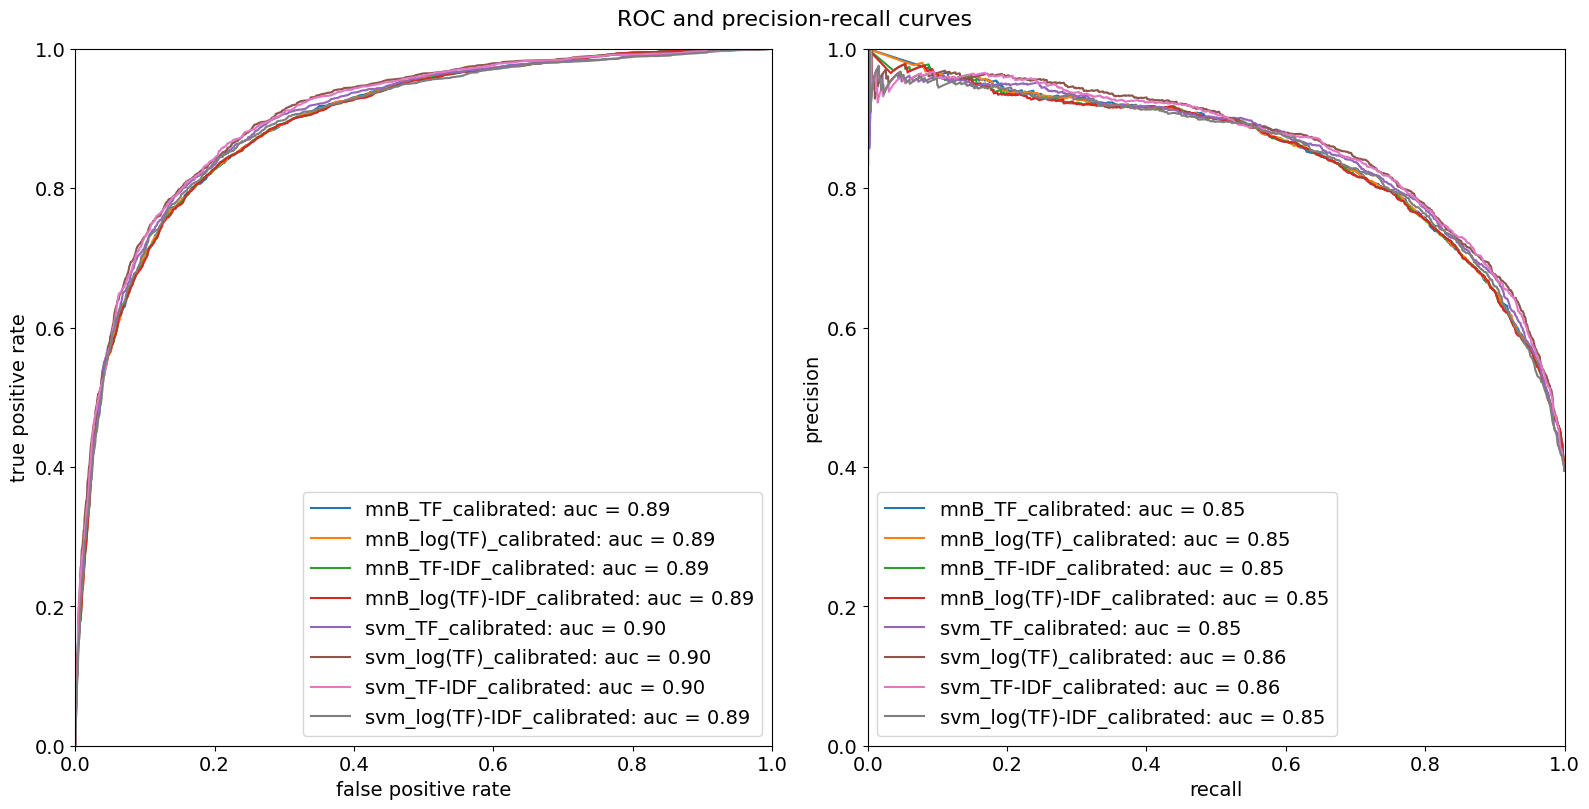

In [ ]:
labels = model_names_calibrated[0:8]
_ = plot_roc_pr(y_test, [np.transpose(y_probas[model_name])[1] for model_name in labels], labels)

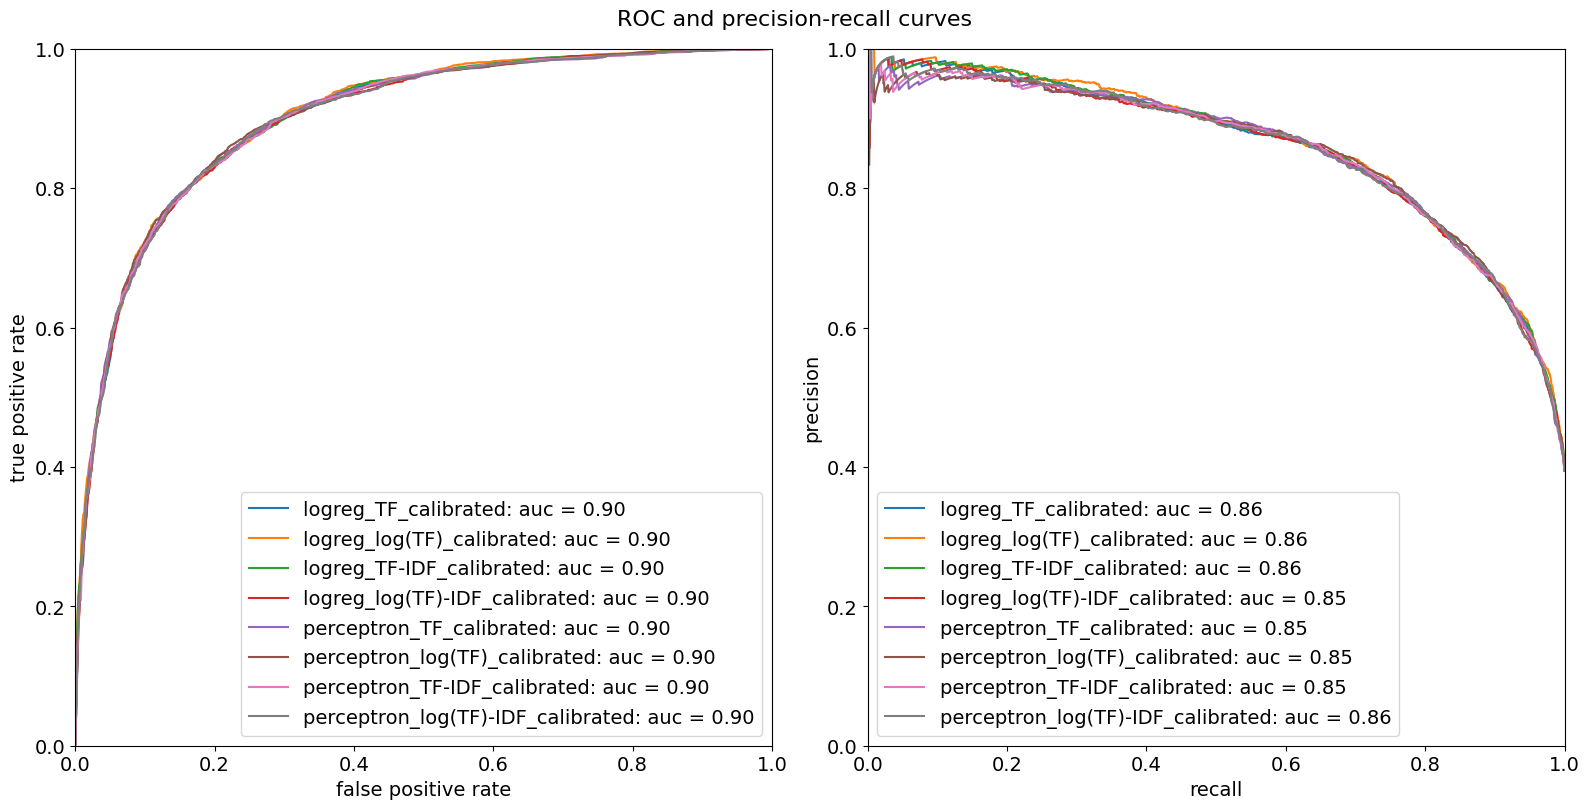

In [ ]:
labels = model_names_calibrated[8:16]
_ = plot_roc_pr(y_test, [np.transpose(y_probas[model_name])[1] for model_name in labels], labels)

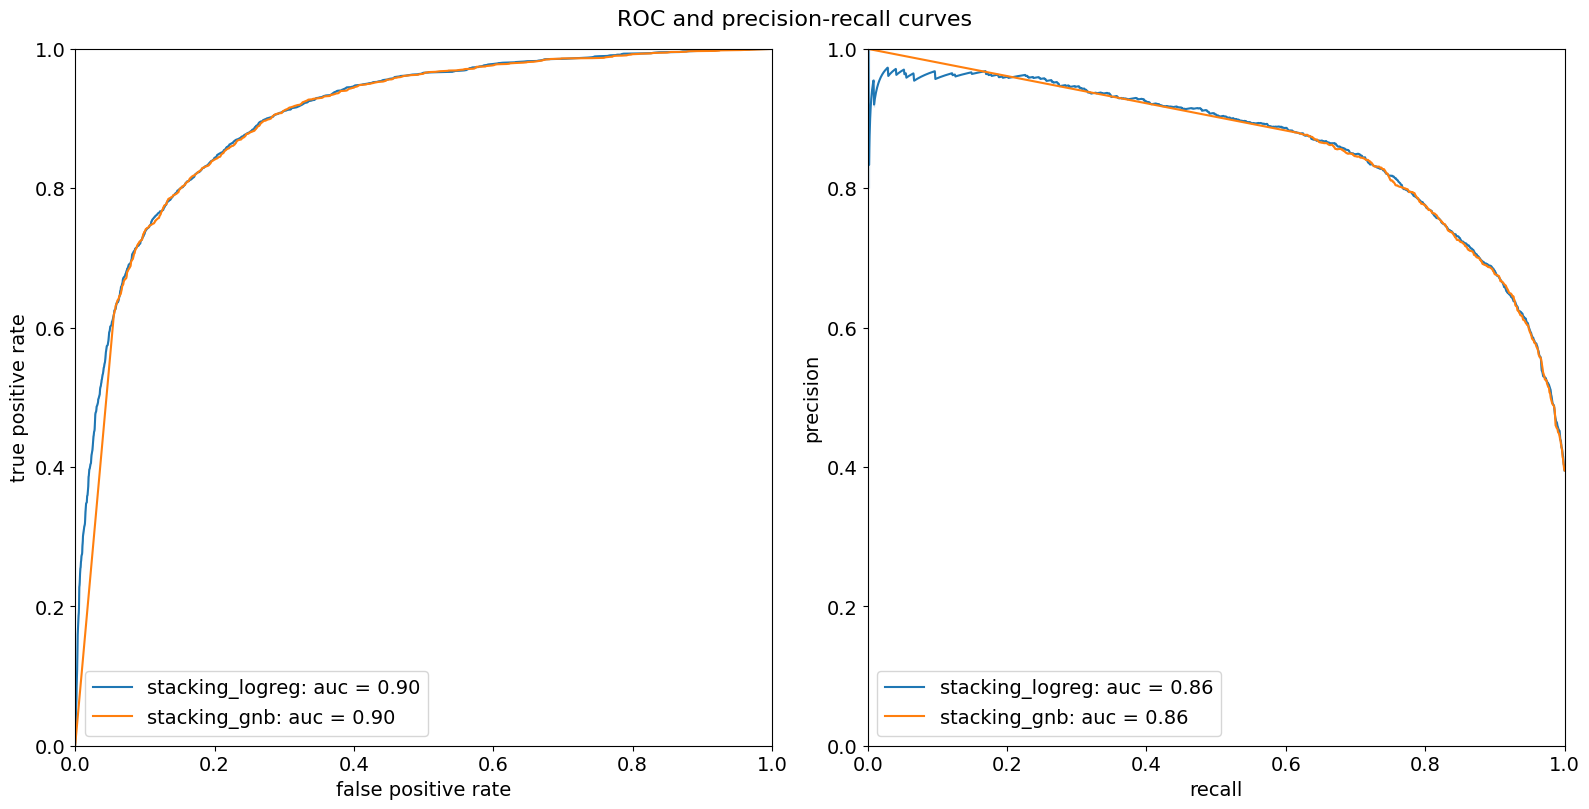

In [ ]:
labels = model_names_calibrated[16:]
_ = plot_roc_pr(y_test, [np.transpose(y_probas[model_name])[1] for model_name in labels], labels)

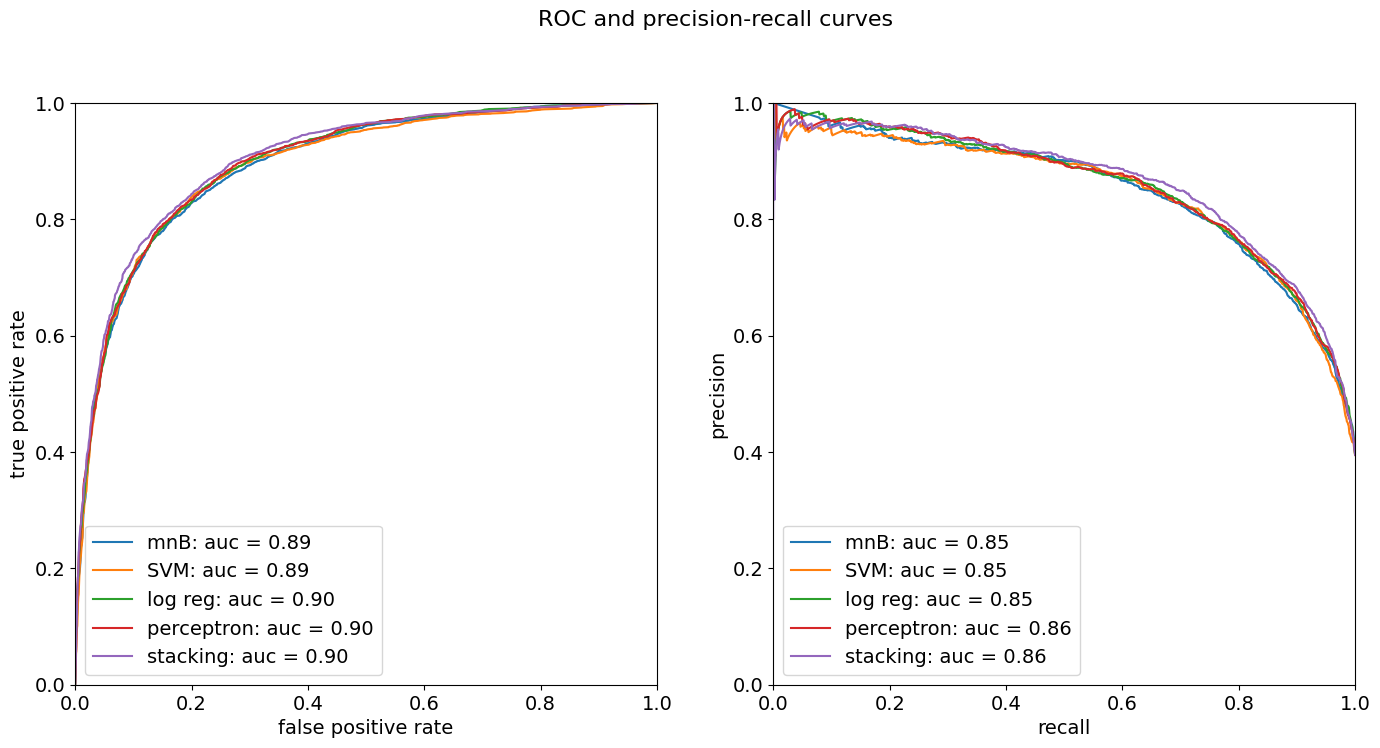

In [ ]:
labels = ['mnB', 'SVM', 'log reg', 'perceptron', 'stacking']
model_names_jpg = ['mnB_TF_calibrated', 'svm_log(TF)-IDF_calibrated', 'logreg_log(TF)-IDF_calibrated', 'perceptron_log(TF)-IDF_calibrated', 'stacking_logreg']
_ = plot_roc_pr(y_test, [np.transpose(y_probas[model_name])[1] for model_name in model_names_jpg], labels, save='roc_pr.jpg', save_format='jpg')

We see some strange behaviour from the Gaussian naive Bayes metaclassifier, but otherwise the curves for all eighteen models are extremely similar.

## Feature importance

The three linear models we have looked at -- logistic regression, SVM and perceptron -- provide coefficients that can be used to represent the predicted impact of a token on the view count. Let's get the model coefficients:

In [ ]:
linear_models_coefs = []

for model_name in ['svm_TF', 'logreg_TF', 'perceptron_TF']:
    linear_models_coefs.append(models[model_name].coef_[0])

linear_models_coefs = np.array(linear_models_coefs)

Which features have the highest coefficients, i.e. the greatest predictive power according to the linear model? Let's rank the features by coefficients for each model:

In [ ]:
def rank_array(values, descending=True):
    sorted_indices = np.argsort(values)
    if descending:
        sorted_indices = [sorted_indices[len(values)-1-idx] for idx in range(len(values))]
    ranks = {idx:rank for rank,idx in enumerate(sorted_indices)}
    return sorted_indices, ranks

In [ ]:
ranks_list = []

for i in range(3):
    _, ranks = rank_array(linear_models_coefs[i])
    ranks_list.append(ranks)

We can now create a function that converts the co-ordinate index of the input feature vector into the features of the original data, which were the video categories and the n-gram vocabularies of the channel and video titles and video descriptions:

In [ ]:
vectorizer_vocabularies = {field: vectorizers[0][field].get_feature_names_out() for field in vectorizers[0]}

categories = video_category_encoder.categories_[0]
N_categories = len(categories)
vocab_sizes = {texts: len(vectorizer_vocabularies[texts]) for texts in vectorizer_vocabularies}

def get_feature_by_index(idx):
    if idx < N_categories:
        return {'feature_type': 'video_category', 'feature': categories[idx]}
    if idx < N_categories + vocab_sizes['channel_title']:
        word = vectorizer_vocabularies['channel_title'][idx - N_categories]
        return {'feature_type': 'channel_title_n_gram', 'feature': tokenizer_decode(word.split(), 'channel_title', cased=False)}
    if idx < N_categories + vocab_sizes['channel_title'] + vocab_sizes['video_title']:
        word = vectorizer_vocabularies['video_title'][idx - N_categories - vocab_sizes['channel_title']]
        return {'feature_type': 'video_title_n_gram', 'feature': tokenizer_decode(word.split(), 'video_title', cased=False)}
    else:
        word = vectorizer_vocabularies['video_description'][idx - N_categories - vocab_sizes['channel_title'] - vocab_sizes['video_title']]
        return {'feature_type': 'video_description_n_gram', 'feature': tokenizer_decode(word.split(), 'video_description', cased=False)}

In [ ]:
feature_ranks = []

for idx in tqdm(range(len(linear_models_coefs[0]))):
    feature = get_feature_by_index(idx)
    feature_ranks.append({'feature_type': feature['feature_type'], 'feature': feature['feature'], 'rank (SVM)': ranks_list[0][idx], 'rank (log reg)': ranks_list[1][idx], 'rank (perceptron)': ranks_list[2][idx]})

  0%|                                               | 0/3508784 [00:00<?, ?it/s]2024-05-19 01:09:12.945926: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 01:09:13.020734: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 01:09:13.401231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 01:09:15.015071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████████████████████████| 3508784/3508784 [00:41<00:00, 84094.87it/s]


In [ ]:
feature_ranks = pd.DataFrame(feature_ranks).sort_values('rank (SVM)')
feature_ranks.head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
10262,channel_title_n_gram,cbse,0,3,4
2213867,video_description_n_gram,2023,1,2,0
276756,video_title_n_gram,commerce,2,4,6
103390,video_title_n_gram,science experiments,3,0,2
4409,channel_title_n_gram,your teacher,4,42,31
303590,video_title_n_gram,insane,5,25,11
5133,channel_title_n_gram,ideas,6,13,38
11868,channel_title_n_gram,best,7,18,39
104476,video_title_n_gram,science song,8,34,7
31201,channel_title_n_gram,science abc,9,109,88


Let's rank the video categories by coefficient:

In [ ]:
feature_ranks[feature_ranks['feature_type'] == 'video_category'].head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
2,video_category,10,4014,6875,1198188
8,video_category,23,6867,4684,162975
6,video_category,20,7560,14502,243202
11,video_category,26,16822,3499196,3501049
1,video_category,2,20679,3505102,3468445
0,video_category,1,25842,3504093,3450831
3,video_category,15,32017,3464664,3334604
9,video_category,24,1172842,3471565,3482788
12,video_category,27,3475500,3502779,3504146
10,video_category,25,3484941,3506311,3494158


We can look at the channel titles, video titles and video descriptions that were most predictive of a video being highly viewed:

In [ ]:
feature_ranks[feature_ranks['feature_type'] == 'channel_title_n_gram'].head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
10262,channel_title_n_gram,cbse,0,3,4
4409,channel_title_n_gram,your teacher,4,42,31
5133,channel_title_n_gram,ideas,6,13,38
11868,channel_title_n_gram,best,7,18,39
31201,channel_title_n_gram,science abc,9,109,88
20166,channel_title_n_gram,cognito,12,1,63
19683,channel_title_n_gram,dear sir,13,68,68
20407,channel_title_n_gram,discovery science,14,268,46
20104,channel_title_n_gram,toppr study,18,63,15
29278,channel_title_n_gram,tyc,19,37,106


In [ ]:
feature_ranks[feature_ranks['feature_type'] == 'video_title_n_gram'].head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
276756,video_title_n_gram,commerce,2,4,6
103390,video_title_n_gram,science experiments,3,0,2
303590,video_title_n_gram,insane,5,25,11
104476,video_title_n_gram,science song,8,34,7
82620,video_title_n_gram,😂,10,39,371
280297,video_title_n_gram,minutes,11,66,23
253163,video_title_n_gram,that,15,6,27
310201,video_title_n_gram,nitin sir,16,204,284
260686,video_title_n_gram,song,17,10,8
136751,video_title_n_gram,chemistry # shorts,27,208,30


In [ ]:
feature_ranks[feature_ranks['feature_type'] == 'video_description_n_gram'].head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
2213867,video_description_n_gram,2023,1,2,0
1220036,video_description_n_gram,ا,23,293,342
2485761,video_description_n_gram,made,37,61,309
1901423,video_description_n_gram,chapter -,38,192,125
2717781,video_description_n_gram,patreon,41,53,122
1969586,video_description_n_gram,how to,47,128,87
1449226,video_description_n_gram,ar,48,102,166
3499767,video_description_n_gram,chart,126,116,89
2770283,video_description_n_gram,bar,153,296,1076
2566796,video_description_n_gram,there,160,123,58


We can also look at the channel titles, video titles and video descriptions that were most predictive of a video having a low view count:

In [ ]:
feature_ranks_unpopular = pd.DataFrame(feature_ranks).sort_values('rank (SVM)', ascending=False)
feature_ranks_unpopular.head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
99809,video_title_n_gram,science,3508783,3508783,3508783
195449,video_title_n_gram,sports,3508782,3508782,3508782
790401,video_description_n_gram,", #",3508781,3508772,3508763
222860,video_title_n_gram,4 |,3508780,3508770,3508781
187940,video_title_n_gram,2018,3508779,3508781,3508770
137188,video_title_n_gram,physics science,3508778,3508767,3508764
7393,channel_title_n_gram,australia,3508777,3508776,3508759
22158,channel_title_n_gram,tictaclearn hindi,3508776,3508741,3508772
356581,video_title_n_gram,| chemistry |,3508775,3508758,3508771
101186,video_title_n_gram,science and,3508774,3508779,3508710


In [ ]:
feature_ranks_unpopular[feature_ranks_unpopular['feature_type'] == 'channel_title_n_gram'].head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
7393,channel_title_n_gram,australia,3508777,3508776,3508759
22158,channel_title_n_gram,tictaclearn hindi,3508776,3508741,3508772
9408,channel_title_n_gram,teachers adda247,3508773,3508756,3508731
37315,channel_title_n_gram,haribokart,3508771,3508747,3508722
28813,channel_title_n_gram,neeraj,3508768,3508686,3508682
2567,channel_title_n_gram,iostouchplayhd,3508765,3508780,3508741
35714,channel_title_n_gram,new scientist,3508764,3508688,3508751
31406,channel_title_n_gram,science by,3508760,3508631,3508652
10559,channel_title_n_gram,krishna,3508759,3508759,3508745
27645,channel_title_n_gram,ictio,3508758,3508742,3508703


In [ ]:
feature_ranks_unpopular[feature_ranks_unpopular['feature_type'] == 'video_title_n_gram'].head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
99809,video_title_n_gram,science,3508783,3508783,3508783
195449,video_title_n_gram,sports,3508782,3508782,3508782
222860,video_title_n_gram,4 |,3508780,3508770,3508781
187940,video_title_n_gram,2018,3508779,3508781,3508770
137188,video_title_n_gram,physics science,3508778,3508767,3508764
356581,video_title_n_gram,| chemistry |,3508775,3508758,3508771
101186,video_title_n_gram,science and,3508774,3508779,3508710
356590,video_title_n_gram,| physics,3508772,3508774,3508778
200909,video_title_n_gram,2020,3508770,3508775,3508774
226959,video_title_n_gram,review,3508769,3508771,3508765


In [ ]:
feature_ranks_unpopular[feature_ranks_unpopular['feature_type'] == 'video_description_n_gram'].head(200)

,feature_type,feature,rank (SVM),rank (log reg),rank (perceptron)
790401,video_description_n_gram,", #",3508781,3508772,3508763
483177,video_description_n_gram,learnfatafat,3508762,3508506,3508013
1964137,video_description_n_gram,biology,3508751,3508769,3508773
1347886,video_description_n_gram,🌐,3508750,3508727,3508733
2273990,video_description_n_gram,social,3508740,3508577,3506653
2033292,video_description_n_gram,part,3508706,3508768,3508780
1755994,video_description_n_gram,ph,3508701,3508679,3508478
1767349,video_description_n_gram,playlist,3508688,3508470,3507553
3144975,video_description_n_gram,# engineering,3508682,3508550,3508614
2357542,video_description_n_gram,university,3508681,3508736,3508501


Considering the accuracy of the models, it is difficult to interpret the feature rankings. The linear classifiers disagree significantly on the rankings, although for the most popular features, the disagreement is often within an order of magnitude.

## Conclusion



Text classification is one of the major applications of machine learning, and we have attempted to apply classical ML methods to classify social media content based on popularity. Whereas text classification methods have been proven to be extremely powerful for tasks such as identifying spam or determining the content of a text, asking whether or not a video description would lead to a video being highly viewed has proven to be much more challenging. We have built a variety of models, and when evaluating them on the test or validation data, seen a number of counter-intuitive results:

1. When performing a token frequency analysis, the inverse document frequency, which determines how much more relevant a token or n-gram is to a particular text than to the entire corpus, is shown to have no effect on the behaviour of the models.
2. Limiting the model vocabulary by removing the rarest tokens and n-grams is extraordinarily detrimental to the accuracy of the model, but model performance is much less sensitive to removal of the most common tokens. There is no obvious explanation for how the models learn so much from terms which occur so rarely.
3. There is almost no difference in performance between the naive Bayes and various linear classifiers. The model accuracy seems to be determined entirely by the vectorised training data and the classification methods we have employed seem to have saturated the statistical bounds on performance.
4. Probability calibration and stacking led to no clear improvement in model performance across the metrics studied.

In the [next notebooks](https://github.com/tommyliphysics/tommyli-ml/blob/main/youtube_predictor/notebooks/distilbert.ipynb) we will explore two further approaches to our classification problem: classical ML models using vector embedding, and deep learning with a large language model.